In [39]:
# Define Constants and imports
import os
from collections import Counter
import pandas as pd
import src
from importlib import reload
import traintracker

import random
raw_dataset_dir = "../dataset/raw"
prep_dataset_dir = "../dataset/preprocessed"

weights_dir="../model_weights/skipgram"
train_tracker_path="../train_tracker"

train_data_dir="../train_tracker"


# Introduction
In this notebook, I'll  implement the [Word2Vec algorithm](https://en.wikipedia.org/wiki/Word2vec) using the skip-gram architecture as a starter step for sentiment analysis creating first the words embeddings then use these embeddings for sentiment analysis

# Data Loading
- load and view the reviews dataset

In [2]:
os.listdir(raw_dataset_dir)

['labels.txt', 'movie.csv', 'reviews.txt', 'text8']

- reviews are line separated and the reviews also

In [3]:
# saving labels to txt file
with open(os.path.join(raw_dataset_dir, "labels.txt"), 'r',encoding="utf-8") as leables_file:
    raw_labels_txt=leables_file.read()
with open(os.path.join(raw_dataset_dir, "reviews.txt"), 'r',encoding="utf-8") as reviews_file:
    raw_reviews_txt=reviews_file.read()

## view words freqencies
- show word freqencies before any preprocessing

In [4]:
words_counter = Counter(raw_reviews_txt.split())


In [5]:
words_df = pd.DataFrame(words_counter.items(), columns=['word', 'count'])
words_df.sort_values(by=['count'], ascending=False, inplace=True)
print(f"no of unique words={len(words_df)}\nno of words ={words_df['count'].sum()}")

no of unique words=381542
no of words =9253570


In [6]:
# get 50 from top , mid and end
src.data_preprocessing.get_head_mid_tail(words_df,50)

,word,count
8,the,455003
51,a,246023
6,and,242041
53,of,226965
27,to,209659
...,...,...
198462,"policewoman's,",1
198464,Palusky,1
198465,Kayle,1
198466,"Timler,",1


In [7]:
words_df.describe()

,count
count,381542.000000
mean,24.253084
std,1240.617558
min,1.000000
25%,1.000000
50%,1.000000
75%,3.000000
max,455003.000000


- high standard deviation due the usage of words like 'the' and using punctuations in words make them counted as diffrent words
- 75% of the words count smaller than 3
- about 50% words appear once , may be misspelled words
- some html tags appear in the words

In [8]:
words_df.median()

C:\Users\Ahmed badr\AppData\Local\Temp\ipykernel_16096\2388422026.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  words_df.median()


count    1.0
dtype: float64

- a words with count =1 appear from the midean to the end due to existance of punctations and the txt exist in thier lower and upper case 

# Data preprocessing
- remove punctuations , set all chars to lowercase
- remove noise words that appear once , that might be misspelling
- remove high frequent words that doesn't add thing to the neighboring word
- save the preprocessed data

**probability of word removal**
- Words that show up often such as "the", "of", and "for" don't provide much context to the nearby words. If we discard some of them, we can remove some of the noise from our data and in return get faster training and better representations. 
- This process is called subsampling by Mikolov.For each word wi) in the training set, 
- we'll discard it with probability given by 
- ![p_remove1.png](./assets/p_remove1.png)![p_remove2.png](./assets/p_remove2.png)
- p--> probability of discarding word
- t--> threshold of word count that the probability of discarding will begin to increase from `T/t`
- f--> frequency of a word
- T--> total number of words
- `set t=100 and T=500000=1e5 ` probability of removal will start to be grater than zero when the f=5000
- ![p_remove_curve.png](./assets/p_remove_curve.png)

## remove invalid chars

In [9]:
prep_txt = src.remove_punctuations(raw_reviews_txt)


In [10]:
words_counter = Counter(prep_txt.split())

words_df = pd.DataFrame(words_counter.items(), columns=['word', 'count'])
words_df.sort_values(by=['count'], ascending=False, inplace=True)
print(f"no of unique words={len(words_df)}\nno of words ={words_df['count'].sum()}")

no of unique words=160310
no of words =9217166


no of unique words decreased from `381542`  to `160310` because we removed punctuation characters so word like `The. ` and `the?` will be `the` and will be counted as one word

In [11]:
def cnt_ranges(df,step,col_name):
  size=len(df)
  df=df.sort_values(by=col_name)
  col_idx=df.columns.get_loc(col_name)

  ranges_list=[]
  smaller_value=0
  bigger_value=step

  df_idx=0
  while(df_idx<size):
    cnt=0
    while(df_idx<size and df.iloc[df_idx,col_idx]<=bigger_value):
      cnt+=1
      df_idx+=1
    if cnt>0:
      ranges_list.append([f"{smaller_value} to {bigger_value}",cnt])
    smaller_value+=step
    bigger_value+=step
  return ranges_list


In [12]:
r=cnt_ranges(words_df,20,'count')

In [13]:
pd.DataFrame(r,columns=["range",'cnt'])

,range,cnt
0,0 to 20,142824
1,20 to 40,6260
2,40 to 60,2771
3,60 to 80,1526
4,80 to 100,1059
...,...,...
397,213640 to 213660,1
398,230740 to 230760,1
399,256820 to 256840,1
400,256900 to 256920,1


In [14]:
src.get_head_mid_tail(words_df,100)

,word,count
8,the,531191
6,and,256916
47,a,256838
49,of,230759
23,to,213654
...,...,...
90777,pointyfinger,1
90776,handymancarpenter,1
90775,paragonbr,1
90774,signorelliscreenplay,1


##  word importance by pos/neg apperance ratio

In [15]:
words_pos_neg_ratio = src.get_word_importance(prep_txt, labels=raw_labels_txt)
                                                                           
min_val,max_val=0,-1

for word,ratio in words_pos_neg_ratio.items():
    min_val=min(ratio,min_val)
    max_val=max(ratio,max_val)
print(f"min_val {min_val}")
print(f"max_val {max_val}")

min_val -4.127134385045092
max_val 4.727387818712341


In [16]:
raw_reviews_txt[:250]

'I grew up (b. 1965) watching and loving the Thunderbirds. All my mates at school watched. We played "Thunderbirds" before school, during lunch and after school. We all wanted to be Virgil or Scott. No one wanted to be Alan. Counting down from 5 becam'

In [17]:
prep_txt[:250]

'i grew up b 1965 watching and loving the thunderbirds all my mates at school watched we played thunderbirds before school during lunch and after school we all wanted to be virgil or scott no one wanted to be alan counting down from 5 became an art fo'

In [18]:
words_p_n_ratio_df=pd.DataFrame(words_pos_neg_ratio.items(),columns=['word','ratio']).sort_values(by=['ratio'])

In [19]:
words_p_n_ratio_df.describe()

,ratio
count,161193.000000
mean,0.048999
std,0.818501
min,-4.127134
25%,-0.693147
50%,0.000000
75%,0.693147
max,4.727388


**Deciding the Ratio for noise**

In [20]:
print("common words")
print(f"pos and negative ratio for 'the' {words_pos_neg_ratio['those']}")
print(f"pos and negative ratio for 'him' {words_pos_neg_ratio['him']}")
print(f"pos and negative ratio for 'her' {words_pos_neg_ratio['her']}")
print(f"pos and negative ratio for 'is' {words_pos_neg_ratio['is']}")
print(f"pos and negative ratio for 'they' {words_pos_neg_ratio['they']}")
print(f"pos and negative ratio for 'did' {words_pos_neg_ratio['did']}")
print(f"pos and negative ratio for 'as' {words_pos_neg_ratio['as']}")
print(f"pos and negative ratio for 'a' {words_pos_neg_ratio['a']}")
print("\nPostive words")

print(f"pos and negative ratio for 'wonderful' {words_pos_neg_ratio['wonderful']}")
print(f"pos and negative ratio for 'amazing' {words_pos_neg_ratio['amazing']}")
print(f"pos and negative ratio for 'good' {words_pos_neg_ratio['good']}")
print(f"pos and negative ratio for 'excellent' {words_pos_neg_ratio['excellent']}")

print("\nnegative words")
print(f"pos and negative ratio for 'bad' {words_pos_neg_ratio['bad']}")
print(f"pos and negative ratio for 'worse' {words_pos_neg_ratio['worse']}")
print(f"pos and negative ratio for 'boring' {words_pos_neg_ratio['boring']}")

common words
pos and negative ratio for 'the' 0.15040138861478275
pos and negative ratio for 'him' 0.23241749635693773
pos and negative ratio for 'her' 0.24583923387574738
pos and negative ratio for 'is' 0.12302609115914889
pos and negative ratio for 'they' -0.2687558382621351
pos and negative ratio for 'did' -0.2160042141353108
pos and negative ratio for 'as' 0.23724039177675732
pos and negative ratio for 'a' 0.037063342877560294

Postive words
pos and negative ratio for 'wonderful' 1.5571694838883434
pos and negative ratio for 'amazing' 1.343095156017315
pos and negative ratio for 'good' 0.005656862045491339
pos and negative ratio for 'excellent' 1.4842294169777621

negative words
pos and negative ratio for 'bad' -1.362353199221966
pos and negative ratio for 'worse' -1.6799782168127269
pos and negative ratio for 'boring' -1.5131861129745143


In [21]:
ratio_threshold=0.27
is_common_word=(words_p_n_ratio_df['ratio']>-ratio_threshold)&(words_p_n_ratio_df['ratio']<ratio_threshold)
is_positive_word=(words_p_n_ratio_df['ratio']>ratio_threshold)
is_negative_word=(words_p_n_ratio_df['ratio']<-ratio_threshold)


common_words=words_p_n_ratio_df[is_common_word].sort_values(by='ratio')

positive_words=words_p_n_ratio_df[is_positive_word].sort_values(by='ratio')

negative_words=words_p_n_ratio_df[is_negative_word].sort_values(by='ratio')


In [22]:
print("common words ",common_words['word'].count())
print("positive words ",positive_words['word'].count())
print("negative words ",negative_words['word'].count())

common words  18124
positive words  75654
negative words  67415


In [23]:
n_words=300
common_words_range=src.get_head_mid_tail(common_words,n_words)
positive_words_range=src.get_head_mid_tail(positive_words,n_words)
negative_words_range=src.get_head_mid_tail(negative_words,n_words)

common_words_range

,word,ratio
3101,foot,-0.269664
813,filthy,-0.269664
45,would,-0.269380
5529,bright,-0.269255
2076,hide,-0.269129
...,...,...
18671,downey,0.269664
19720,1986,0.269664
1528,told,0.269740
369,certain,0.269763


In [30]:
# add exceptional words
excep=['story','movie','good','film','movies']
for word in excep:
  words_pos_neg_ratio[word]=1

## remove words with high and low freq

In [25]:
import src.data_preprocessing as prep
reload(prep)

<module 'src.data_preprocessing' from 'D:\\2022 acheivments\\Projects\\DeepLearning NanoDegree\\sentiment-analysis-RNN\\src\\data_preprocessing.py'>

<module 'src.data_preprocessing' from 'D:\\2022 acheivments\\Projects\\DeepLearning NanoDegree\\sentiment-analysis-RNN\\src\\data_preprocessing.py'>

In [26]:
filtered_prep_txt, noise_words,prob_drop_dist = prep.remove_noise(prep_txt, p_drop_dist_threshold=1e4, min_prob_drop=0.8, min_freq=20,min_rev_freq=5,common_words_threshold=0.27,word_importance_dict=words_pos_neg_ratio)

In [27]:
prob_drop_word_df=pd.DataFrame(prob_drop_dist.items(),columns=["word",'probabilty of drop']).sort_values(by=['probabilty of drop'],ascending=False)

In [28]:
prob_drop_word_df.head(150)

,word,probabilty of drop
8,the,0.958344
6,and,0.940103
47,a,0.940094
49,of,0.936800
23,to,0.934318
...,...,...
1447,saw,0.570905
502,right,0.570648
1006,almost,0.568963
410,come,0.566377


In [29]:
noise_words

['reticent',
 'hilaraious',
 'trashcult',
 'tovah',
 'radius',
 'frankenstien',
 'moviestory',
 'childrensfamily',
 'realizeshe',
 'lovejust',
 'youwatch',
 'aardvark',
 'languagebrief',
 'crapand',
 'eversocareful',
 'feebleminded',
 'apoplectic',
 'speedsbr',
 'reinforcements',
 'wasabi',
 'annick',
 'psychoteacher',
 'walshs',
 'itbuy',
 'goddaughter',
 'famerodgers',
 'failded',
 'doxy',
 'japaneseamerican',
 '8090',
 'demonization',
 'greying',
 'tacking',
 'abercrombie',
 'combed',
 'bleh',
 'heartfc',
 'timberlakes',
 'stupidy',
 'hesitating',
 'moviehated',
 'beautybr',
 'gawky',
 'dutrone',
 'indolently',
 'nordby',
 'logicbut',
 'lymi',
 'stomachssickening',
 'completionist',
 'enzyme',
 'costumingbr',
 'englishlinear',
 'unhip',
 'openair',
 'vendettabr',
 'shouldthats',
 'prefeature',
 'pouts',
 'daylightsounds',
 'obout',
 'it',
 'whiteout',
 'baggy',
 'snowmans',
 'schade',
 'slits',
 'megadose',
 'fritzs',
 'bigcast',
 'mindframe',
 'zaitochi',
 'verhoevenbr',
 'meantime

In [30]:
print(len(noise_words))
prep_txt=filtered_prep_txt

142368


In [31]:
words_counter = Counter(prep_txt.split())

words_df = pd.DataFrame(words_counter.items(), columns=['word', 'count'])
words_df.sort_values(by=['count'], ascending=False, inplace=True)
print(f"no of unique words={len(words_df)}\nno of words ={words_df['count'].sum()}")

no of unique words=17942
no of words =5130422


In [32]:
r=cnt_ranges(words_df,10,'count')

In [33]:
pd.DataFrame(r,columns=["range",'cnt']).head(100)

,range,cnt
0,10 to 20,512
1,20 to 30,3929
2,30 to 40,2319
3,40 to 50,1606
4,50 to 60,1165
...,...,...
95,960 to 970,11
96,970 to 980,8
97,980 to 990,4
98,990 to 1000,17


In [34]:
words_df[words_df['count']<100]

,word,count
11361,lifes,99
6981,toronto,99
6823,programs,99
3690,seeming,99
7893,akshay,99
...,...,...
17265,odious,20
12904,excitingbr,20
12912,sonia,20
12929,pods,20


In [35]:
src.get_head_mid_tail(words_df,1000)

,word,count
31,movie,66976
62,his,45522
129,just,28030
128,if,26971
95,good,22980
...,...,...
17265,odious,20
12904,excitingbr,20
12912,sonia,20
12929,pods,20


In [41]:
raw_reviews_list=raw_reviews_txt.split('\n')
prep_reviews_list=prep_txt.split('\n')


In [45]:
rand_idx=random.randint(0,len(raw_reviews_list))
print("review before\n")
print(raw_reviews_list[rand_idx])
print()
print("review after\n")
print(prep_reviews_list[rand_idx])



review before

Christopher Lee is one of my favorite actors! I'm trying to view all of his work. He has been known to single-handedly save movies with his presence. Unfortunately, this is not one of them. This movie suffers from a low budget and it's production values are disturbing. Please...for the love of Christopher....avoid this film!

review after

christopher lee my favorite actors im trying view his work been known singlehandedly save movies his presence unfortunately them movie suffers low budget production values disturbing love 


In [44]:
# save preprocessed reviews
with open(os.path.join(prep_dataset_dir, "reviews.txt"), 'w',encoding="utf-8") as reviews_file:
    reviews_file.write(prep_txt)

In [45]:
prep_words_counter = Counter(prep_txt.split())
prep_words_df = pd.DataFrame(prep_words_counter.items(), columns=['word', 'count'])
print(f"no of unique words={len(prep_words_df)}\nno of words ={prep_words_df['count'].sum()}")
prep_words_df.sort_values(by=['count'], ascending=False, inplace=True)

no of unique words=17943
no of words =5189833


In [46]:
prep_words_df.head(100)

,word,count
31,movie,66976
73,film,59411
62,his,45522
130,just,28030
129,if,26971
...,...,...
65,should,7690
327,through,7646
120,those,7593
251,im,7563


- only `.` is removed with size `327192` , it was the second most frequent word , the std will decrease a little

In [47]:
prep_words_df.describe()

,count
count,17943.000000
mean,289.239982
std,1373.175361
min,20.000000
25%,31.000000
50%,56.000000
75%,143.000000
max,66976.000000


In [48]:
prep_reviews_list = prep_txt.split('\n')
len(prep_reviews_list)

40000

# Skip-Gram Data loader
- Dataset Loader will load the txt data
- count the frequency for each word and total frequency which used in selecting the noise words which doesn't appear in the word context
- save a map for word to index and index to word , change txt to int
- iterate over the data , return each iteration `(input,target,noise_words)` the target which is the no of words around the given word with size `w` and the input will be the word repeated `w` times
    - ex if the txt is
    - ` They celebrated his birthday with a big party.`
    - and we are at the word `birthday` and the window size = 4
    - input `[birthday,birthday,birthday,birthday]` target `[celebrated,his,with,a] `
<br><br>
- **selecting noise word**
<br><br>
- we will select from a probability distribution (probability of selecting a word as noise word) n-words
<br><br>
- ![noise_removal_eq1.png](./assets/noise_removal_eq1.png)
- ![noise_removal_eq1_curve.png](./assets/noise_removal_eq1_curve.png)
<br><br>
- `f--> word frequency`
- `t--> total of words frequencies`
- with a power of `3/8` will make the probability of selecting low frequent words little higher
<br><br>
- ![noise_removal_eq2.png](./assets/noise_removal_eq2.png)
- ![noise_removal_eq2_curve.png](./assets/noise_removal_eq2_curve.png)


In [49]:
with open(os.path.join(prep_dataset_dir, 'reviews.txt'),encoding="utf-8") as prep_file:
    prep_txt = prep_file.read()
prep_reviews_list = prep_txt.split('\n')
len(prep_reviews_list)

40000

In [50]:
rev_skip_gram_data = src.Word2VecDataset(prep_txt, window_size=4, no_noise_outputs=10, batch_size=256)

In [51]:
rev_skip_gram_data.save_word2int(prep_dataset_dir)

In [52]:
word2intx=src.utils.load_json(os.path.join(prep_dataset_dir,"word2int.json"))


In [53]:
print(f"int value for amazing {word2intx['amazing']}")
print(f"int value for good {word2intx['good']}")

int value for amazing 444
int value for good 6


In [54]:
itrr = iter(rev_skip_gram_data)
word, target, noise = next(itrr)

In [55]:
print(f"words_in shape {word.shape}")
print(f"target_words shape {target.shape}")
print(f"noise_words shape {noise.shape}")

words_in shape torch.Size([1366])
target_words shape torch.Size([1366])
noise_words shape torch.Size([1366, 10])


In [56]:
rev_skip_gram_data.no_unique_words

17944

In [60]:
import torch
from torch import optim
import numpy as np
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# instantiating the model
embedding_dim = 256
model = src.SkipGram(rev_skip_gram_data.no_unique_words, embedding_dim).to(device)

# Training

- feed-forward processes
    - for window size=3 , batch_size=2
    - txt --> `[1,2,3,4,5,6,7,8,9,10]` after being changed from txt to int
    - take input of an index of a word repeated with window_size*2
    - example at word 4
    ```
                 batch 1       batch 2
      input  [ 4,4,4,4,4,4, 5,5,5,5,5,5 ]
      target [ 1,2,3,5,6,7, 2,3,4,6,7,8 ]
    ```
- loss function
- ![loss_function1.png](./assets/loss_function1.png)
<br><br>

- Dot product between input word and random words need to be minimized to zero
  - ![loss_function2.png](./assets/loss_function2.png)
<br><br>
- selection or random words will be done using uni-gram distribution for the word
- Dot product between input word and output word need to be maximized to be zero also
<br><br>
  - ![loss_function3.png](./assets/loss_function3.png)

In [1]:
# show word and the closest 5 words to it before trainning
from src import utils
reload(utils)
utils.closest_words(model.input_embedding,rev_skip_gram_data.int2word)


KeyboardInterrupt



In [68]:

# using the loss that we defined
criterion = src.NegativeSamplingLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 25

In [69]:
latest_weights_path=traintracker.latest_weights_path(weights_dir)
print(latest_weights_path)
state_dict=torch.load(latest_weights_path,map_location='cpu')
model.load_state_dict(state_dict)

../model_weights/skipgram/12_07 16_45 Train_(2.84019) .pt


<All keys matched successfully>

In [ ]:
src.skipgram_train(model=model,epochs=epochs,skip_gram_data=rev_skip_gram_data,device=device,optimizer=optimizer,criterion=criterion,train_data_dir=train_data_dir,weights_dir=weights_dir)

- showing cosine similarity between random words after trainnig

In [71]:
# show word and the closest 5 words to it after training
utils.closest_words(model.input_embedding,rev_skip_gram_data.int2word)

too | very, pretty, overly, bit, enough
plot | storyline, story, premise, script, narrative
how | why, really, where, mean, believe
bad | awful, terrible, good, horrible, badbr
two | three, four, couple, 2, 3
such | truly, many, example, kind, great
time | timebr, spent, week, hour, day
love | hate, loved, friendship, loves, romantic
convincing | believable, realistic, credible, effective, likable
biggest | major, big, greatest, worst, huge
intelligent | witty, smart, clever, mature, talented
filled | full, lots, plenty, contains, loaded
sadly | unfortunately, simply, shame, however, largely
kills | killing, killed, kill, dies, murdering
amount | amounts, lot, minuscule, lots, considerable
credit | kudos, deserves, award, praise, mention
...



In [85]:
train_intervals=pd.read_csv(train_data_dir+'/train_data.csv')

In [86]:
len(train_intervals)

17

In [87]:
train_intervals

,epoch idx from,model architecture,batch size,optimizer,embedding_size,window_size,no noise samples,changed hyperParameters
0,1,SkipGram(\n (input_embedding): Embedding(4634...,128,Adam (\nParameter Group 0\n amsgrad: False\...,256,5,25,"['model architecture', 'batch size', 'optimize..."
1,1,SkipGram(\n (input_embedding): Embedding(4634...,512,Adam (\nParameter Group 0\n amsgrad: False\...,256,5,25,"['batch size', 'optimizer']"
2,1,SkipGram(\n (input_embedding): Embedding(1033...,256,Adam (\nParameter Group 0\n amsgrad: False\...,256,3,25,"['model architecture', 'batch size', 'window_s..."
3,17,SkipGram(\n (input_embedding): Embedding(2338...,256,Adam (\nParameter Group 0\n amsgrad: False\...,256,3,25,['model architecture']
4,27,SkipGram(\n (input_embedding): Embedding(2338...,512,Adam (\nParameter Group 0\n amsgrad: False\...,128,3,50,"['model architecture', 'batch size', 'embeddin..."
5,30,SkipGram(\n (input_embedding): Embedding(2338...,512,Adam (\nParameter Group 0\n amsgrad: False\...,512,3,25,"['model architecture', 'embedding_size', 'no n..."
6,40,SkipGram(\n (input_embedding): Embedding(3811...,256,Adam (\nParameter Group 0\n amsgrad: False\...,300,5,25,"['model architecture', 'batch size', 'embeddin..."
7,51,SkipGram(\n (input_embedding): Embedding(3811...,256,Adam (\nParameter Group 0\n amsgrad: False\...,300,5,25,['optimizer']
8,52,SkipGram(\n (input_embedding): Embedding(3815...,512,Adam (\nParameter Group 0\n amsgrad: False\...,300,5,25,"['model architecture', 'batch size']"
9,52,SkipGram(\n (input_embedding): Embedding(3815...,512,Adam (\nParameter Group 0\n amsgrad: False\...,300,5,25,['optimizer']


- best results at the sentiment analysis section was on the last two intervals of training starting from epoch 115

In [99]:
train_intervals[-2:]

,epoch idx from,model architecture,batch size,optimizer,embedding_size,window_size,no noise samples,changed hyperParameters
15,114,SkipGram(\n (input_embedding): Embedding(1794...,256,Adam (\nParameter Group 0\n amsgrad: False\...,256,4,10,"['model architecture', 'embedding_size']"
16,128,SkipGram(\n (input_embedding): Embedding(1794...,256,Adam (\nParameter Group 0\n amsgrad: False\...,256,4,10,['optimizer']


In [89]:
epochs_data=pd.read_csv(train_data_dir+'/epochs_data.csv')

In [91]:
epochs_data[115:]

,Train Loss,no train rows,Time taken (M),Date,Time
115,3.054564,5189632,5.68,07/12/2022,13:25:00
116,3.007079,5189632,5.77,07/12/2022,13:31:00
117,2.980684,5189632,6.05,07/12/2022,13:37:00
118,2.963794,5189632,6.22,07/12/2022,13:43:00
119,2.952011,5189632,6.31,07/12/2022,13:49:00
120,2.943582,5189632,6.40,07/12/2022,13:55:00
121,2.936728,5189632,6.50,07/12/2022,14:02:00
122,2.931645,5189632,6.44,07/12/2022,14:08:00
123,2.927267,5189632,6.50,07/12/2022,14:15:00
124,2.923833,5189632,6.54,07/12/2022,14:21:00


<AxesSubplot:>

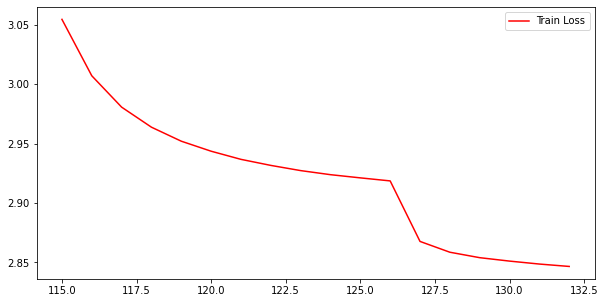

In [98]:
epochs_data[115:].plot(y='Train Loss',figsize=(10,5),color='red')

In [100]:
train_intervals[-2:]

,epoch idx from,model architecture,batch size,optimizer,embedding_size,window_size,no noise samples,changed hyperParameters
15,114,SkipGram(\n (input_embedding): Embedding(1794...,256,Adam (\nParameter Group 0\n amsgrad: False\...,256,4,10,"['model architecture', 'embedding_size']"
16,128,SkipGram(\n (input_embedding): Embedding(1794...,256,Adam (\nParameter Group 0\n amsgrad: False\...,256,4,10,['optimizer']


- at epoch 128 I changed the learn rate from 0.001 to 0.0001 and the loss decreased as you see